# Storms database
Create a database of all North Atlantic hurricanes based on NOAA online archive.

In [1]:
import pathlib
import sys
module_dir = pathlib.Path("").parent.resolve()
root_dir = module_dir.parent
source_dir = root_dir.joinpath("source")
model_dir = root_dir.joinpath("model")
asvlite_wrapper_dir = root_dir.joinpath("dependency", "ASVLite", "wrapper", "cython")
sys.path.insert(0, str(source_dir))
sys.path.insert(0, str(asvlite_wrapper_dir))

In [2]:
import requests
import re
import pandas as pd
import numpy as np
import epsg
from os.path import exists
from bs4 import BeautifulSoup
from datetime import datetime
from shapely.geometry import Polygon, LineString, Point
from storms_archive import Storms_archieve
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Set plot size
width = 18
height = 9
plt.rcParams['figure.figsize'] = [width, height]

In [3]:
storms_file = root_dir.joinpath("data", "storms")

In [4]:
# Helper function to set the correct sign for latitudes and longitudes
def convert_latitude_longitude(latitude, longitude):
        lat = 0
        long = 0
        # If latitude contains "N", then remove it and convert it to a +ve float, else remove "S" and convert it to a -ve float.
        if "N" in latitude:
            lat = float(latitude.replace("N", ""))
        else:
            lat = -1 * float(latitude.replace("S", ""))
        # If longitude contains "W", then remove it and convert it to a -ve float, else remove "E" and convert it to a +ve float.
        if "W" in longitude:
            long = -1 * float(longitude.replace("W", ""))
        else:
            long = float(longitude.replace("E", ""))
        return (lat, long)

In [5]:
# Helper function to get the html text from a url.
count_urls_visited = 0
def get_html(url):
    html = None
    while html == None:
        try:
            html = requests.get(url).text
        except Exception as e:
            print("Attempt to access url {} failed with the message {}. Reattempting...".format(url, str(e)))
            continue
    global count_urls_visited
    count_urls_visited += 1
    return html

In [6]:
# Helper function to split a line to list of words.
def line_to_list(line):
    words = [word.strip() for word in line.split()]
    words = list(filter(None, words)) # Remove any empty strings
    return words

In [7]:
# Helper function to read the csv file and convert the strings to numbers and datetime.
def read_csv(file):
    df = pd.read_csv(file)
    time_stamps = []
    path = []
    min_atm_pressures = []
    max_sustained_windspeeds = []
    for i in range(len(df)):
        # Convert the list of strings such as "datetime.datetime(1999, 8, 18, 21, 0)" into datetime object.
        times = df.loc[i, "time_stamps"]
        times = times[1:-1] # Remove "[" and "]"
        times = times.split("datetime.datetime")
        times = list(filter(None, times)) # Remove any empty strings
        times = [item.replace("(", "") for item in times]
        times = [item.replace(")", "") for item in times]
        times = [item.strip() for item in times]
        times = [item[:-1] if item.endswith(",") else item for item in times]
        times = [datetime.strptime(time, '%Y, %m, %d, %H, %M') for time in times]
        time_stamps.append(times)
        # Convert the list of strings such as "(-93.7, 20.1)" into a tuple of numbers.
        points = df.loc[i, "path(longitude, latitude)"]
        points = points[1:-1] # Remove "[" and "]"
        points = points.split(")")
        points = list(filter(None, points)) # Remove any empty strings
        points = [item.replace("(", "") for item in points]
        points = [item[1:].strip() if item.startswith(",") else item for item in points]
        points = [item.split(",") for item in points]
        points = [(float(item[0]), float(item[1])) for item in points]
        path.append(points)
        # Convert the list of strings to numbers
        pressures = df.loc[i, "min_atm_pressure(MB)"]
        pressures = pressures[1:-1] # Remove "[" and "]"
        pressures = pressures.replace("'", "")
        pressures = pressures.split(",")
        pressures = list(filter(None, pressures)) # Remove any empty strings
        pressures = [int(item) for item in pressures]
        min_atm_pressures.append(pressures)
        # Convert the list of strings to numbers
        wind_speeds = df.loc[i, "max_sustained_windspeed(knots)"]
        wind_speeds = wind_speeds[1:-1] # Remove "[" and "]"
        wind_speeds = wind_speeds.replace("'", "")
        wind_speeds = wind_speeds.split(",")
        wind_speeds = list(filter(None, wind_speeds)) # Remove any empty strings
        wind_speeds = [int(item) for item in wind_speeds]
        max_sustained_windspeeds.append(wind_speeds)
    df["time_stamps"] = time_stamps
    df["path(longitude, latitude)"] = path
    df["min_atm_pressure(MB)"] = min_atm_pressures
    df["max_sustained_windspeed(knots)"] = max_sustained_windspeeds
    return df

In [8]:
# Create the storms archieve if it does not exist
storms_archieve = Storms_archieve(str(storms_file))
df = storms_archieve.get_storms()

In [9]:
print("Total number of web pages visited = {}".format(count_urls_visited))

Total number of web pages visited = 0


In [10]:
df

,year,storm_name,time_stamps,"path(long,lat)",min_atm_pressure(MB),max_sustained_windspeed(knots),"predicted_paths(long,lat)"
0,1999.0,hurricane_bret,"[1999-08-18 21:00:00, 1999-08-19 03:00:00, 199...","[(-93.7, 20.1), (-94.3, 19.6), (-93.8, 19.9), ...","[1010.0, 1007.0, 1007.0, 1008.0, 1006.0, 1000....","[30.0, 30.0, 30.0, 30.0, 35.0, 40.0, 45.0, 55....","[[(-93.7, 20.1), (-94.2, 20.2), (-95.0, 20.5),..."
1,1999.0,hurricane_cindy,"[1999-08-19 03:00:00, 1999-08-19 09:00:00, 199...","[(-19.4, 13.6), (-21.3, 14.0), (-22.1, 14.1), ...","[1003.0, 1003.0, 1003.0, 1003.0, 1002.0, 1002....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 35....","[[(-19.4, 13.6), (-20.9, 13.8), (-22.9, 14.2),..."
2,1999.0,hurricane_dennis,"[1999-08-24 03:00:00, 1999-08-24 09:00:00, 199...","[(-68.3, 21.1), (-69.1, 21.5), (-71.0, 22.5), ...","[1008.0, 1008.0, 1008.0, 1008.0, 1005.0, 1008....","[30.0, 30.0, 30.0, 45.0, 40.0, 40.0, 40.0, 55....","[[(-68.3, 21.1), (-69.3, 21.6), (-70.6, 22.2),..."
3,1999.0,hurricane_floyd,"[1999-09-07 21:00:00, 1999-09-08 03:00:00, 199...","[(-46.2, 14.6), (-47.5, 15.2), (-49.1, 15.6), ...","[1008.0, 1007.0, 1005.0, 1003.0, 1000.0, 1000....","[25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 50.0, 50....","[[(-46.2, 14.6), (-48.1, 14.8), (-50.6, 15.3),..."
4,1999.0,hurricane_gert,"[1999-09-11 15:00:00, 1999-09-11 21:00:00, 199...","[(-24.7, 12.3), (-26.8, 13.1), (-28.5, 13.1), ...","[1004.0, 1004.0, 1004.0, 1004.0, 1001.0, 996.0...","[30.0, 30.0, 30.0, 30.0, 35.0, 55.0, 60.0, 60....","[[(-24.7, 12.3), (-27.1, 12.6), (-30.3, 13.0),..."
...,...,...,...,...,...,...,...
176,2022.0,hurricane_ian,"[2022-09-23 09:00:00, 2022-09-23 15:00:00, 202...","[(-68.6, 13.9), (-70.1, 14.2), (-71.3, 14.7), ...","[1006.0, 1006.0, 1006.0, 1005.0, 1003.0, 1003....","[30.0, 30.0, 30.0, 35.0, 40.0, 40.0, 40.0, 45....","[[(-68.6, 13.9), (-70.2, 14.4), (-72.6, 14.7),..."
177,2022.0,hurricane_julia,"[2022-10-06 15:00:00, 2022-10-06 21:00:00, 202...","[(-67.0, 11.4), (-68.7, 11.6), (-69.8, 11.9), ...","[1006.0, 1003.0, 1004.0, 1004.0, 1002.0, 1002....","[30.0, 30.0, 30.0, 30.0, 35.0, 35.0, 40.0, 50....","[[(-67.0, 11.4), (-69.0, 11.8), (-71.9, 12.3),..."
178,2022.0,hurricane_lisa,"[2022-10-30 21:00:00, 2022-10-31 03:00:00, 202...","[(-73.6, 15.7), (-74.9, 15.8), (-76.1, 15.8), ...","[1005.0, 1005.0, 1006.0, 1003.0, 1002.0, 1002....","[35.0, 35.0, 35.0, 35.0, 40.0, 40.0, 40.0, 50....","[[(-73.6, 15.7), (-74.9, 16.0), (-76.6, 16.3),..."
179,2022.0,hurricane_martin,"[2022-11-01 15:00:00, 2022-11-01 21:00:00, 202...","[(-55.9, 35.3), (-54.5, 35.4), (-53.4, 35.1), ...","[997.0, 991.0, 991.0, 989.0, 983.0, 974.0, 973...","[45.0, 50.0, 50.0, 55.0, 65.0, 75.0, 75.0, 75....","[[(-55.9, 35.3), (-53.9, 35.4), (-50.7, 36.1),..."


## Grid map for Gulf of Mexico

In [11]:
# The region of interest
north = 50
south = 15
east = -45
west = -100

In [12]:
# Cells in the grid
cells = []
for latitude in range(south, north, 1):
    for longitude in range(west, east, 1):
        cell = (latitude+1, longitude+1, latitude, longitude) # north, east, south, west
        cells.append(cell)

In [13]:
# Polygons for cells
polygons = []
for cell in cells:
    lat1, long1, lat0, long0 = cell
    long1, lat1 = epsg.GCS_to_PCS(long1, lat1)
    long0, lat0 = epsg.GCS_to_PCS(long0, lat0)
    polygon = Polygon([(long0, lat0), (long1, lat0), (long1, lat1), (long0, lat1)])
    polygons.append(polygon)

In [14]:
# For each cell, find the storms that passed through it
storms_in_cells = []
for i in range(len(polygons)):
    polygon = polygons[i]
    storms_in_cell = []
    for j in range(len(df)):
        year = df.loc[j, "year"]
        storm = df.loc[j, "storm_name"]
        path = df.loc[j, "path(long,lat)"]
        path = [epsg.GCS_to_PCS(long, lat) for (long, lat) in path]
        path = LineString(path)
        # Check for intersection of path with cell
        intersection = polygon.intersection(path)
        if not intersection.is_empty:
            storms_in_cell.append("{} {}".format(year, storm))
    storms_in_cells.append(storms_in_cell)    

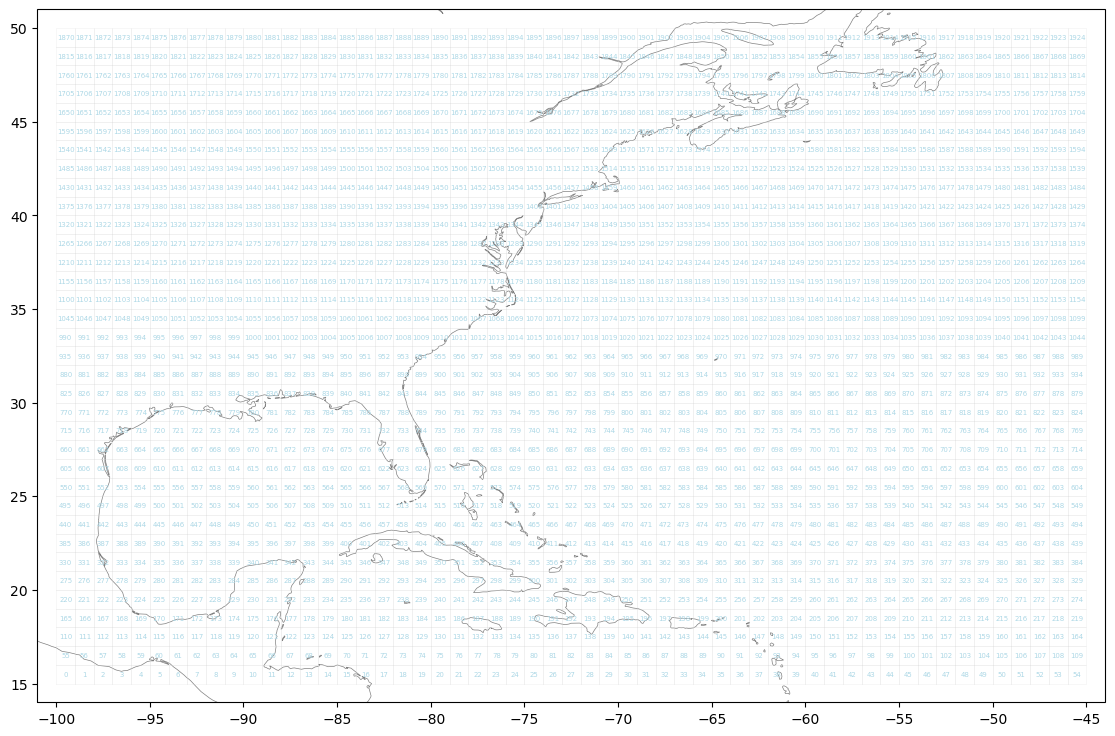

In [15]:
# Plot the grids
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot the cells
for i in range(len(polygons)):
    polygon = polygons[i]
    longitudes = []
    latitudes = []
    edges = polygon.boundary
    for point in edges.coords:
        longitude, latitude = epsg.PCS_to_GCS(*point)
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.25, transform=ccrs.Geodetic())
    # Also show the cell index at the centre of each cell
    longitude = (max(longitudes) + min(longitudes))/2.0
    latitude = (max(latitudes) + min(latitudes))/2.0
    plt.text(longitude, latitude, str(i), color="lightblue", size=5, ha='center', va='center')
plt.show()

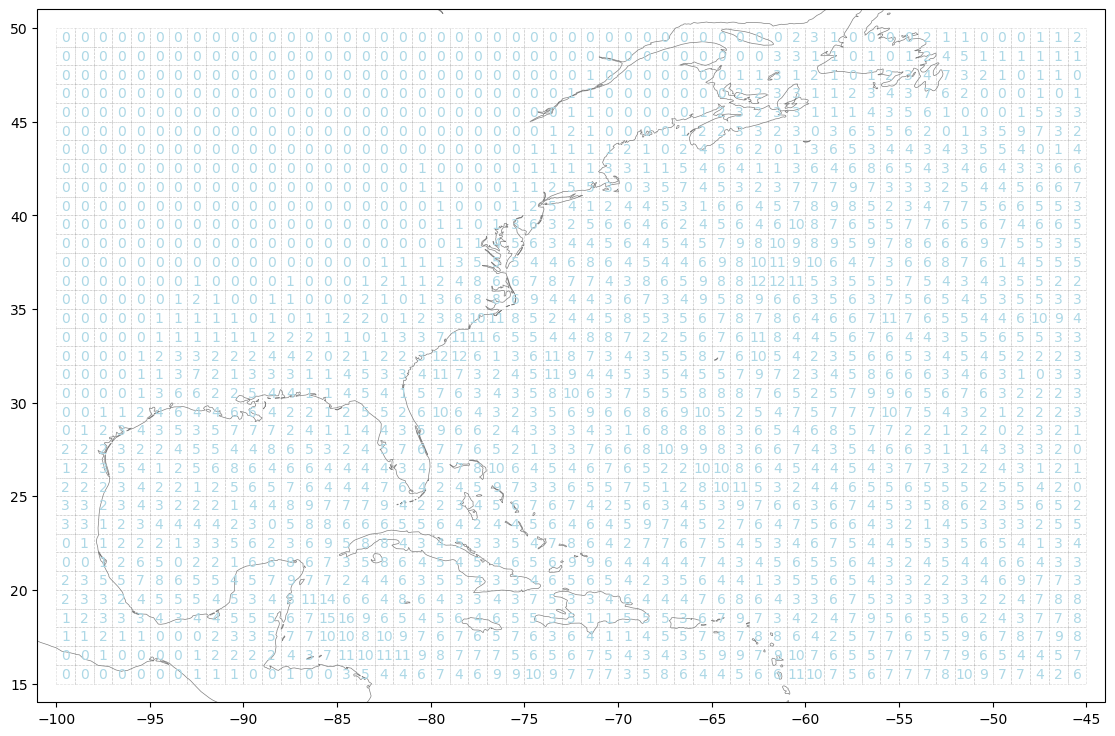

In [16]:
# Plot the storm counts
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot the cells
for i in range(len(polygons)):
    polygon = polygons[i]
    longitudes = []
    latitudes = []
    edges = polygon.boundary
    for point in edges.coords:
        longitude, latitude = epsg.PCS_to_GCS(*point)
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='grey', linestyle='--', linewidth=0.5, alpha=0.25, transform=ccrs.Geodetic())
    # Also show the cell index at the centre of each cell
    longitude = (max(longitudes) + min(longitudes))/2.0
    latitude = (max(latitudes) + min(latitudes))/2.0
    plt.text(longitude, latitude, len(storms_in_cells[i]), color="lightblue", ha='center', va='center')
plt.show()

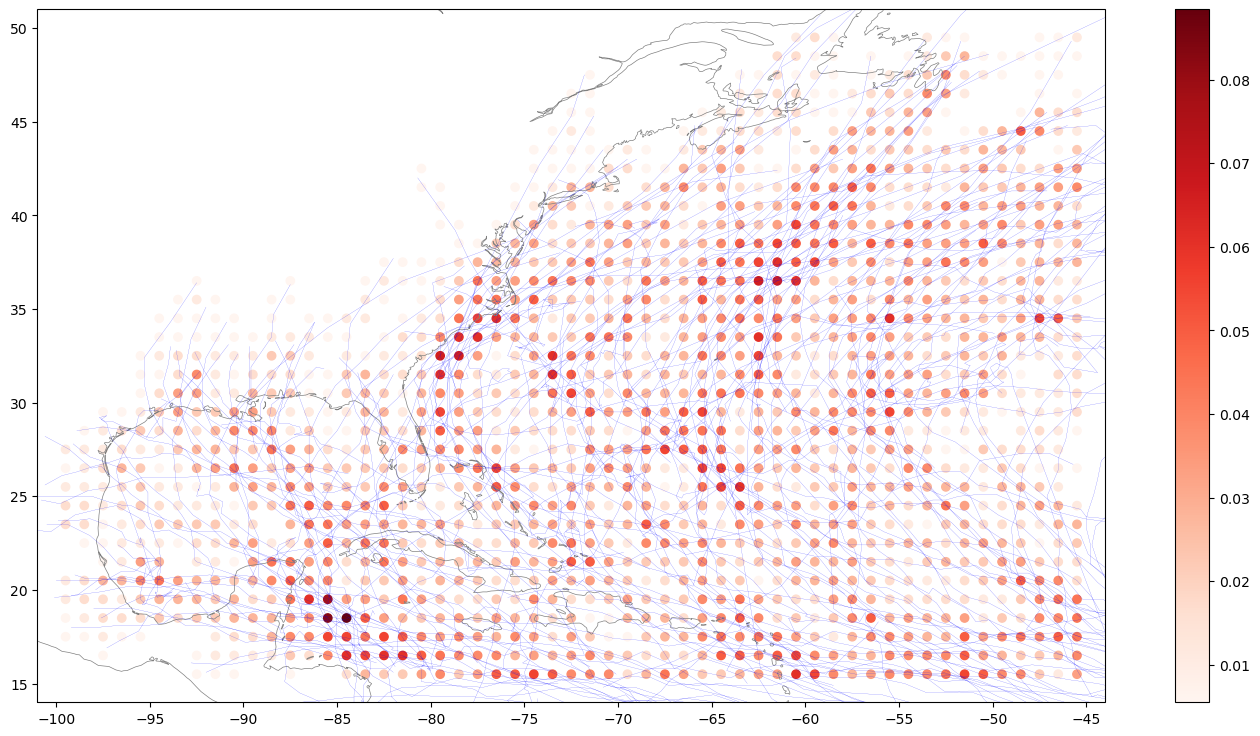

In [17]:
# Plot the storm counts
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot storm paths
for i in range(len(df)):
    path = df.loc[i, "path(long,lat)"]
    longitudes = []
    latitudes = []
    for point in path:
        longitude, latitude = point
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='blue', linewidth=0.1, transform=ccrs.Geodetic())
# Heat map of counts
longitudes = []
latitudes = []
probabilities = []
for i in range(len(polygons)):
    N, E, S, W = cells[i]
    longitude = (E + W)/2.0
    latitude = (N + S)/2.0
    probability = len(storms_in_cells[i])/len(df)
    if probability > 0:
        longitudes.append(longitude)
        latitudes.append(latitude)
        probabilities.append(probability)
sc = plt.scatter(x=longitudes, y=latitudes, c=probabilities, cmap=plt.get_cmap("Reds"))
plt.colorbar(sc)
plt.show()

## Sliding window to identify region of max activity

In [18]:
# Cells in the grid
cells = []
slider_delta = 0.5
cell_size = 5 # 5 lat x 5 long
for latitude in np.arange(south, north-cell_size+1, slider_delta):
    for longitude in np.arange(west, east-cell_size+1, slider_delta):
        cell = (latitude+cell_size, longitude+cell_size, latitude, longitude) # north, east, south, west
        cells.append(cell)

In [19]:
# Polygons for cells
polygons = []
for cell in cells:
    lat1, long1, lat0, long0 = cell
    long1, lat1 = epsg.GCS_to_PCS(long1, lat1)
    long0, lat0 = epsg.GCS_to_PCS(long0, lat0)
    polygon = Polygon([(long0, lat0), (long1, lat0), (long1, lat1), (long0, lat1)])
    polygons.append(polygon)

In [20]:
# For each cell, find the storms that passed through it
storms_in_cells = []
for i in range(len(polygons)):
    polygon = polygons[i]
    storms_in_cell = []
    for j in range(len(df)):
        year = df.loc[j, "year"]
        storm = df.loc[j, "storm_name"]
        path = df.loc[j, "path(long,lat)"]
        path = [epsg.GCS_to_PCS(long, lat) for (long, lat) in path]
        path = LineString(path)
        # Check for intersection of path with cell
        intersection = polygon.intersection(path)
        if not intersection.is_empty:
            storms_in_cell.append("{} {}".format(year, storm))
    storms_in_cells.append(storms_in_cell)    

In [21]:
max_count = 0
index_max_cell = None
for i in range(len(storms_in_cells)):
    count = len(storms_in_cells[i])
    if count > max_count:
        max_count = count
        index_max_cell = i

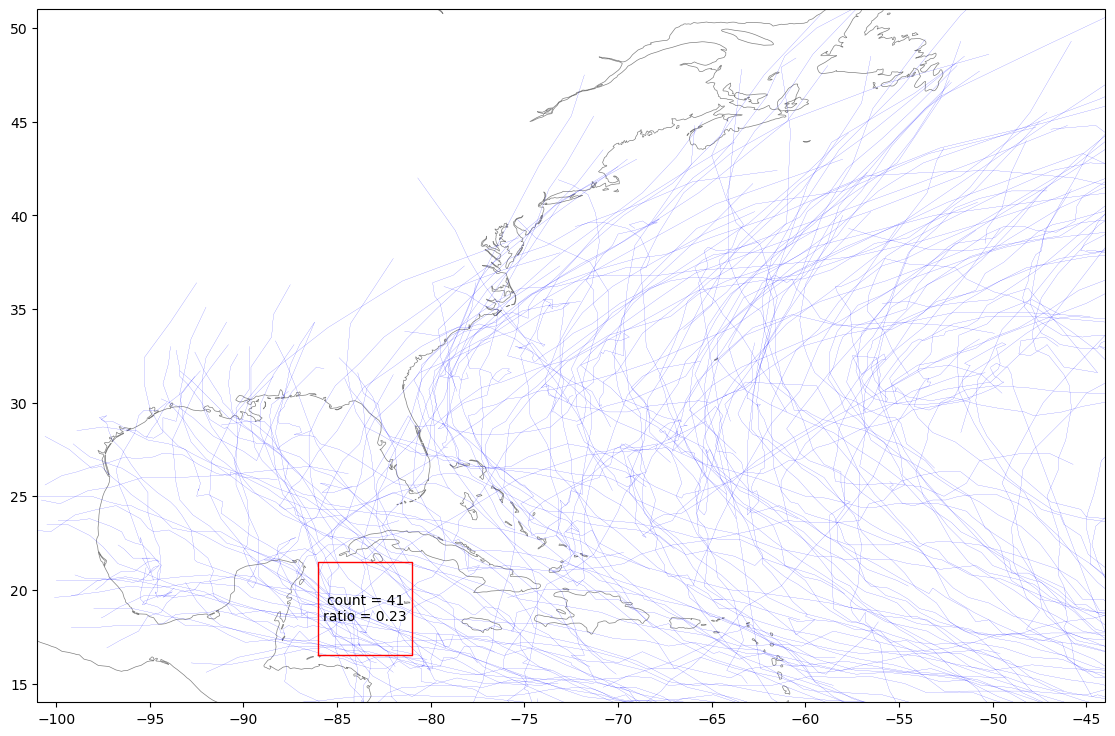

In [22]:
# Plot the grids
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_yticks(range(south, north+1, 5), minor=False)
ax.set_xticks(range(west, east+1, 5), minor=False)
# Set the extent of the plot
ax.set_xlim(west-1, east+1)
ax.set_ylim(south-1, north+1)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot storm paths
for i in range(len(df)):
    path = df.loc[i, "path(long,lat)"]
    longitudes = []
    latitudes = []
    for point in path:
        longitude, latitude = point
        longitudes.append(longitude)
        latitudes.append(latitude)
    plt.plot(longitudes, latitudes, color='blue', linewidth=0.1, transform=ccrs.Geodetic())
# Plot the max cell
polygon = polygons[index_max_cell]
longitudes = []
latitudes = []
edges = polygon.boundary
for point in edges.coords:
    longitude, latitude = epsg.PCS_to_GCS(*point)
    longitudes.append(longitude)
    latitudes.append(latitude)
plt.plot(longitudes, latitudes, color='red', linestyle='-', linewidth=1, transform=ccrs.Geodetic())
# Also show the cell index at the centre of each cell
longitude = (max(longitudes) + min(longitudes))/2.0
latitude = (max(latitudes) + min(latitudes))/2.0
plt.text(longitude, latitude, "count = {}\nratio = {:.2f}".format(max_count, max_count/len(df)), color="black", ha='center', va='center')
plt.show()

In [23]:
print("North {}, East{}, South{}, West{}".format(*cells[index_max_cell]))

North 21.5, East-81.0, South16.5, West-86.0
